# Import Library

In [ ]:
pip install --upgrade tensorflow keras

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import keras

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation, RandomBrightness
from keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

# EDA

#### Load Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train_dir = '/content/drive/MyDrive/Dataset_Capstone/faceshape_grey/train'

test_dir = '/content/drive/MyDrive/Dataset_Capstone/faceshape_grey/test'

val_dir = '/content/drive/MyDrive/Dataset_Capstone/faceshape_grey/validation'

In [8]:
from collections import Counter

def check_distribution(dir_path):
    class_counts = Counter()
    for class_name in os.listdir(dir_path):
        class_dir = os.path.join(dir_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print("Distribusi data di folder train:", check_distribution(train_dir))
print("Distribusi data di folder validation:", check_distribution(val_dir))
print("Distribusi data di folder test baru:", check_distribution(test_dir))

Distribusi data di folder train: Counter({'Square': 799, 'Oblong': 798, 'Heart': 798, 'Oval': 797, 'Round': 789})
Distribusi data di folder validation: Counter({'Heart': 100, 'Oblong': 100, 'Square': 100, 'Round': 99, 'Oval': 99})
Distribusi data di folder test baru: Counter({'Square': 100, 'Oblong': 100, 'Oval': 100, 'Heart': 100, 'Round': 100})


In [9]:
class_names = ['Oblong', 'Heart', 'Round', 'Square', 'Oval']

In [45]:
def create_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=True
    )

    validation_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=False
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=False
    )

    return train_ds, validation_ds, test_ds

In [46]:
# Create datasets with or without data augmentation
train_ds, validation_ds, test_ds = create_datasets()

Found 3981 files belonging to 5 classes.
Found 498 files belonging to 5 classes.
Found 500 files belonging to 5 classes.


In [48]:
# from tensorflow.keras.applications.vgg16 import VGG16

IMG_SHAPE = (224, 224, 3)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

tuning_layer_name = 'block_14_expand'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# Membekukan semua layer sebelum tuning_layer
for layer in base_model.layers[:tuning_index]:
    layer.trainable = False


# base_model = VGG16(input_shape=IMG_SHAPE,
#                    include_top=False,
#                    weights='imagenet')

# for layer in base_model.layers:
#   layer.trainable = False

# Layer augmentasi
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomContrast(0.3),
    RandomTranslation(0.1, 0.1),
], name='data_augmentation')

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [49]:
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,526,080 (5.82 MB)

 Non-trainable params: 731,904 (2.79 MB)

In [51]:
learning_rate = 0.0001

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.95:
            self.model.stop_training = True
            print("\nReached 95% accuracy so cancelling training!")

early_stopping_callback = EarlyStoppingCallback()

In [ ]:
EPOCH = 70

history = model.fit(
    train_ds,
    epochs=EPOCH,
    verbose=1,
    validation_data=validation_ds,
    callbacks=[early_stopping_callback]
)

Epoch 1/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.2333 - loss: 1.8054 - val_accuracy: 0.2450 - val_loss: 1.7132
Epoch 2/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.3541 - loss: 1.4837 - val_accuracy: 0.3534 - val_loss: 1.6053
Epoch 3/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.4176 - loss: 1.3947 - val_accuracy: 0.3855 - val_loss: 1.5186
Epoch 4/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.4643 - loss: 1.2971 - val_accuracy: 0.3855 - val_loss: 1.4954
Epoch 5/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.5332 - loss: 1.1970 - val_accuracy: 0.4016 - val_loss: 1.5836
Epoch 6/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.5552 - loss: 1.1199 - val_accuracy: 0.3775 - val_loss: 1.6281
Epoch 7/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.6063 - loss: 1.0292 - val_accuracy: 0.4799 - val_loss: 1.3635
Epoch 8/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.6222 - loss: 0

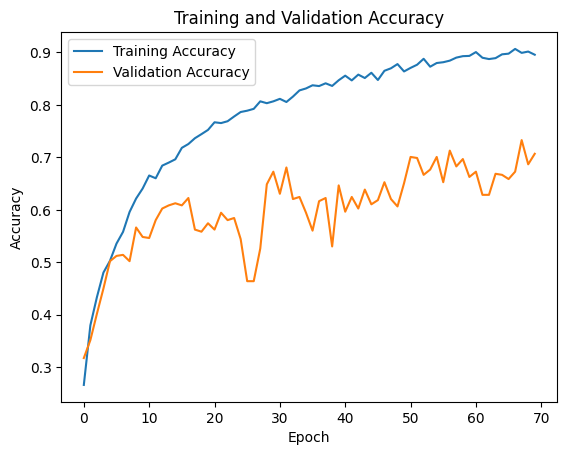

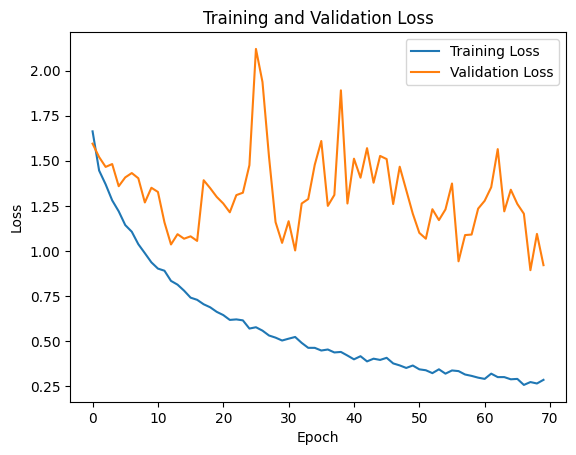

In [28]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# test_dir2 = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/test'

# test_ds

# Dapatkan prediksi untuk data testing
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Dapatkan label sebenarnya untuk data testing
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Hitung dan print metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# You can print the metrics:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step
Accuracy: 0.706
Precision: 0.7296861327835583
Recall: 0.706
F1 Score: 0.7072614005037029


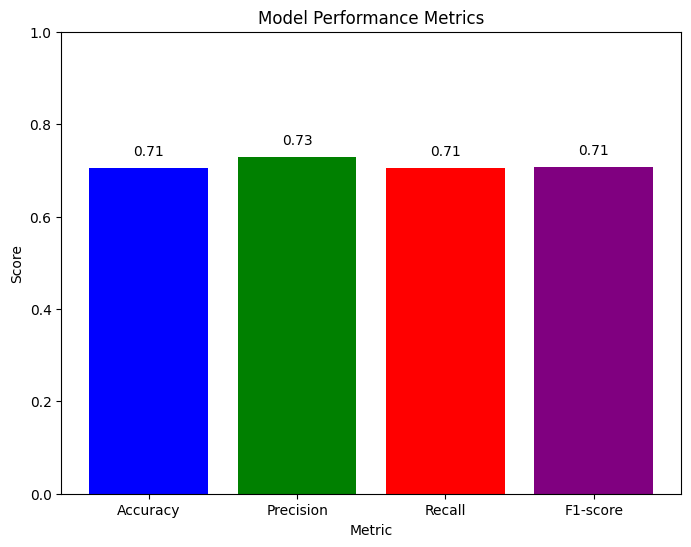

In [30]:
# Data metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim([0, 1])  # Mengatur batas sumbu y antara 0 dan 1

# Menambahkan label nilai di atas setiap bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()

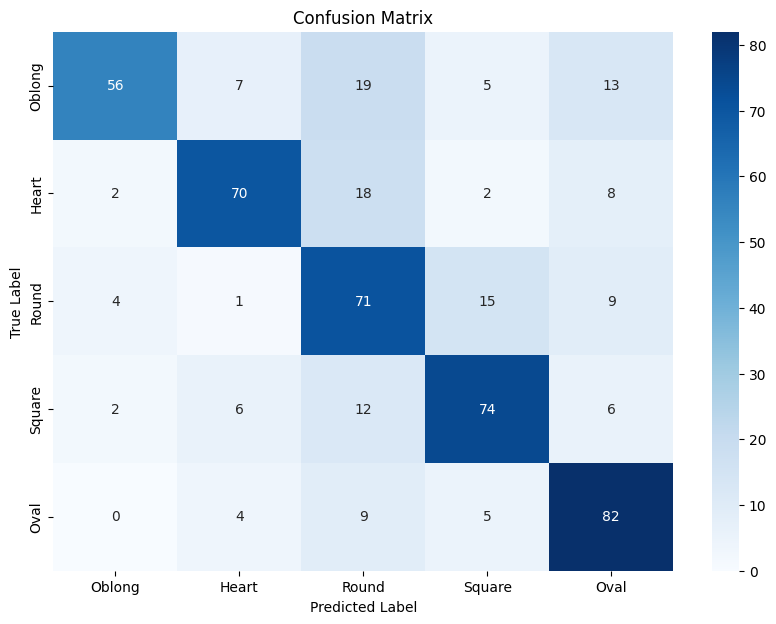

In [31]:
# Buat dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
model.save('/content/drive/MyDrive/Model/Model_V7.h5')

In [ ]:
model_path = '/content/drive/MyDrive/Model_V3.keras'
tf.keras.models.save_model(
    model, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None)

## Convert to tfLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Model/Model_V7.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
EPOCH = 70
BATCH_SIZE = 32

history = model.fit(
    train_ds,
    epochs=EPOCH,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

In [35]:
history_1 = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    validation_data=validation_ds,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9109 - loss: 0.2471 - val_accuracy: 0.7028 - val_loss: 1.0111
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9054 - loss: 0.2573 - val_accuracy: 0.6908 - val_loss: 1.1572
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9147 - loss: 0.2416 - val_accuracy: 0.6727 - val_loss: 1.3728
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.9146 - loss: 0.2551 - val_accuracy: 0.6145 - val_loss: 1.7158
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9183 - loss: 0.2418 - val_accuracy: 0.6486 - val_loss: 1.3887
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9065 - loss: 0.2527 - val_accuracy: 0.7088 - val_loss: 1.0414
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.9131 - loss: 0.2343 - val_accuracy: 0.7209 - val_loss: 0.9582
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.9196 - loss: 0

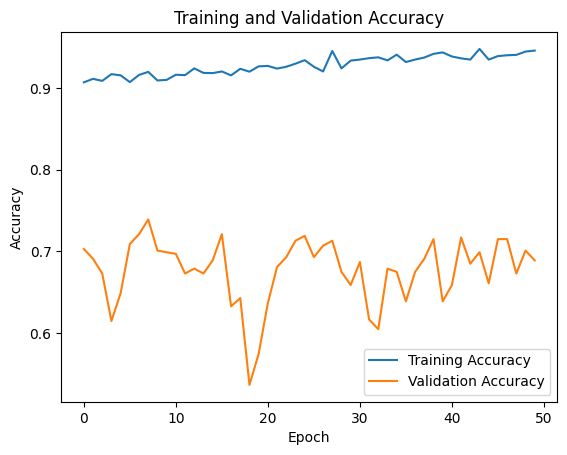

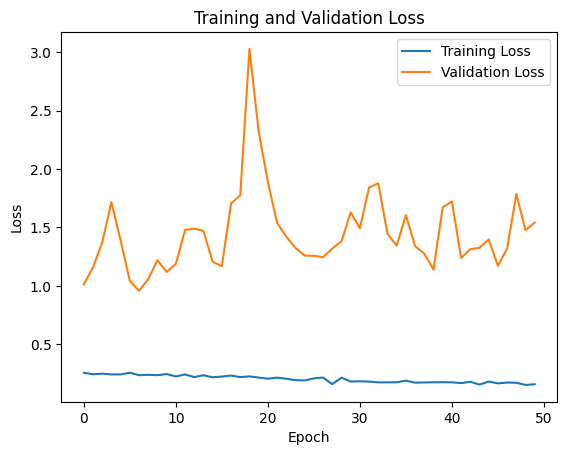

In [36]:
# Visualisasi akurasi
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [37]:
test_dir2 = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/test'

In [38]:
def create_datasets2():

    test_ds_new = tf.keras.utils.image_dataset_from_directory(
        test_dir2,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=False
    )

    return test_ds_new

test_ds_new = create_datasets2()

Found 505 files belonging to 5 classes.


In [42]:
# Dapatkan prediksi untuk data testing
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Dapatkan label sebenarnya untuk data testing
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Hitung dan print metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# You can print the metrics:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
Accuracy: 0.704
Precision: 0.7528972298119304
Recall: 0.704
F1 Score: 0.7010606473647123


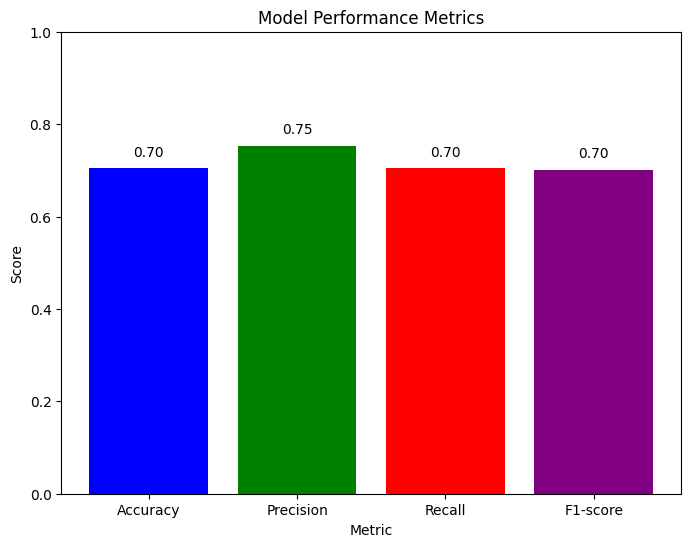

In [43]:
# Data metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim([0, 1])  # Mengatur batas sumbu y antara 0 dan 1

# Menambahkan label nilai di atas setiap bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()

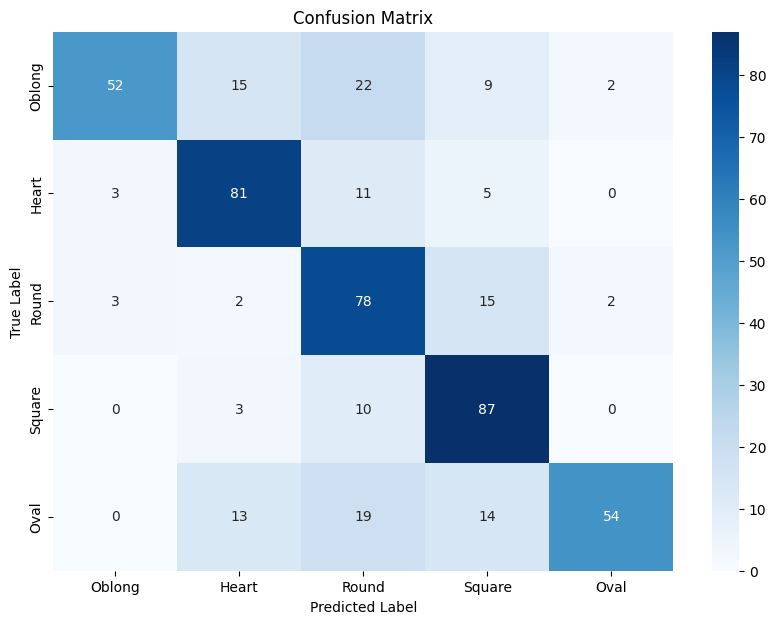

In [44]:
# Buat dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
history_2 = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.7212 - loss: 0.7415 - val_accuracy: 0.5644 - val_loss: 1.1940
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.7184 - loss: 0.7686 - val_accuracy: 0.5426 - val_loss: 1.2729
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.7222 - loss: 0.7556 - val_accuracy: 0.5327 - val_loss: 1.2352
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 203ms/step - accuracy: 0.7195 - loss: 0.7643 - val_accuracy: 0.5881 - val_loss: 1.1622
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 173ms/step - accuracy: 0.7082 - loss: 0.7693 - val_accuracy: 0.5327 - val_loss: 1.2335
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.7138 - loss: 0.7547 - val_accuracy: 0.5683 - val_loss: 1.2028
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.7196 - loss: 0.7411 - val_accuracy: 0.5624 - val_loss: 1.1988
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.7184 - loss: 0